In [51]:
from pathlib import Path
from ops.ecris.analysis.io import read_csd_from_file_pair

CSD_FILEPATHS = list(Path('./data/csds').glob('csd_*'))
FILES_START: int = 40
N_FILES: int = 20
csds = [read_csd_from_file_pair(file) for file in CSD_FILEPATHS[FILES_START:FILES_START + N_FILES]]
print(f'Loaded {len(csds)} of {len(CSD_FILEPATHS)} CSD files.')

Loaded 20 of 1335 CSD files.


In [6]:
from ops.ecris.analysis.m_over_q import estimate_m_over_q
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from itertools import permutations
import random
from IPython.display import clear_output

from ops.ecris.analysis.model.csd import CSD
from ops.ecris.analysis.model.element import Element
from ops.ecris.analysis.peaks import find_element_peaks

def sorted_permutations(to_permute):
    return [list(p) for p in permutations(to_permute, r=7) if list(p) == sorted(p)] 

def get_training_peaks(csd: CSD):
    clear_output(wait=True)
    csd.m_over_q = estimate_m_over_q(csd)
    oxygen = Element('Oxygen', 'O', 16, 8)
    o2_peaks = find_element_peaks(csd, oxygen, 0.2)
    all_peaks, properties = find_peaks(csd.beam_current, prominence=0.1)
    sorted_peaks = np.flip(np.argsort(properties['prominences']))
    plt.plot(csd.m_over_q, csd.beam_current, '--')
    plt.plot(csd.m_over_q[o2_peaks.indexes], o2_peaks.beam_current, '+')
    for i in range(1, 9):
        plt.axvline(16/i, ls='--', alpha=0.25, c='k')
    plt.grid()
    plt.show()
    accept = input("Accept peaks? (Y/n)")
    if accept == 'n':
        return []


    for highest in [10, 15]:
        highest_peaks = sorted(all_peaks[sorted_peaks][:highest])
        permutations = sorted_permutations([int(v) for v in highest_peaks])
        total_sets = len(permutations)
        for i, p in enumerate(permutations):
            if p == o2_peaks.indexes:
                correct_peaks = permutations.pop(i)
                break
        if len(permutations) != total_sets - 1:
            print(f'Failed to fit with {highest=} with {len(permutations)=}')
            continue
        if len(permutations) > 1:
            bad_peaks = [permutations[i] for i in [random.randint(0, len(permutations) - 1) for _ in range(49)]]
        elif len(permutations) == 1:
            bad_peaks = permutations[0]
        else:
            bad_peaks = []
        training_peaks = [correct_peaks] + bad_peaks
        return training_peaks
    return []

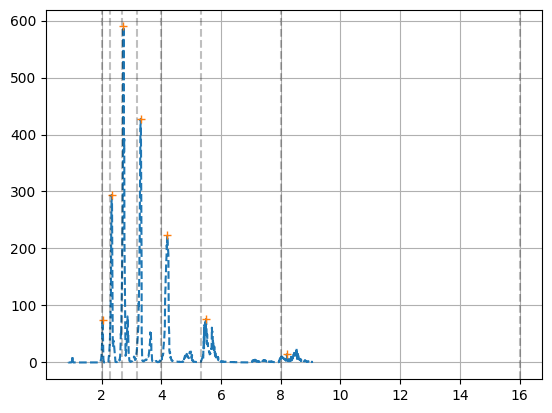

Failed to fit with highest=10 with len(permutations)=120
Failed to fit with highest=15 with len(permutations)=6435
failed=9/20


In [52]:
x = []
y = []
failed = 0
for csd in csds:
    training_peaks = get_training_peaks(csd)
    if not training_peaks:
        failed += 1
        continue
    x.extend(training_peaks)
    y.extend([1] + (len(training_peaks) - 1)*[0])
print(f'{failed=}/{len(csds)}')

In [53]:
x_array = np.array(x)
y_array = np.array(y)
print(x_array.shape, y_array.shape)
x_training = np.load('x_training.npy')
y_training = np.load('y_training.npy')
print(x_training.shape, y_training.shape)
x_output = np.concatenate([x_training, x_array])
y_output = np.concatenate([y_training, y_array])
print(x_output.shape, y_output.shape)

(550, 7) (550,)
(1350, 7) (1350,)
(1900, 7) (1900,)


In [54]:
np.save('x_training.bak', x_training)
np.save('y_training.bak', y_training)
np.save('x_training', x_output)
np.save('y_training', y_output)

In [55]:
from sklearn.neural_network import MLPClassifier

X = np.load('x_training.npy')
Y = np.load('y_training.npy')
clf = MLPClassifier(hidden_layer_sizes=(6), solver='lbfgs')
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=6, solver='lbfgs')

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

hidden_layers = [(i, j, k) for i in range(0, 8) for j in range(0,8) for k in range(0,8)]

parameter_space = {
    'hidden_layer_sizes': hidden_layers,
    'solver': ['sgd', 'adam', 'lbfgs'],
}

mlp = MLPClassifier(max_iter=100)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X, Y)

/home/rehak/repos/ops/ecris.analysis/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rehak/repos/ops/ecris.analysis/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rehak/repos/ops/ecris.analysis/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/rehak/repos/ops/ecris.analysis/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the 

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(0, 0, 0), (0, 0, 1), (0, 0, 2),
                                                (0, 0, 3), (0, 0, 4), (0, 0, 5),
                                                (0, 0, 6), (0, 0, 7), (0, 1, 0),
                                                (0, 1, 1), (0, 1, 2), (0, 1, 3),
                                                (0, 1, 4), (0, 1, 5), (0, 1, 6),
                                                (0, 1, 7), (0, 2, 0), (0, 2, 1),
                                                (0, 2, 2), (0, 2, 3), (0, 2, 4),
                                                (0, 2, 5), (0, 2, 6), (0, 2, 7),
                                                (0, 3, 0), (0, 3, 1), (0, 3, 2),
                                                (0, 3, 3), (0, 3, 4), (0, 3, 5), ...],
                         'solver': ['sgd', 'adam', 'lbfgs']})

In [40]:
def estimate_correct_peaks(csd):
    all_peaks, properties = find_peaks(csd.beam_current, prominence=0.1, height=(10, None))
    sorted_peaks = np.flip(np.argsort(properties['prominences']))
    highest_peaks = sorted(all_peaks[sorted_peaks][:15])
    sorted_peaks = sorted_permutations([int(v) for v in highest_peaks])
    return sorted_peaks, clf.predict_proba(sorted_peaks)

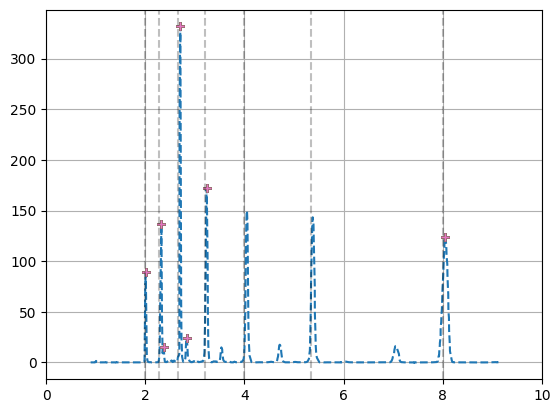

In [58]:
CSD_FILEPATHS = list(Path('./data/csds').glob('csd_*'))
FILE_NUM = random.randint(0, len(CSD_FILEPATHS))
csd = read_csd_from_file_pair(CSD_FILEPATHS[FILE_NUM])
estimated_peaks, probabilities = estimate_correct_peaks(csd)
two_highest = np.flip(np.argsort(probabilities[:,1]))
csd.m_over_q = estimate_m_over_q(csd)

plt.plot(csd.m_over_q, csd.beam_current, '--')
for highest_prob in two_highest:
    highest_prob = np.argmax(probabilities, axis=0)[1]
    highest_peaks = estimated_peaks[highest_prob]
    plt.plot(csd.m_over_q[highest_peaks], csd.beam_current[highest_peaks], '+')
for i in range(1, 9):
    plt.axvline(16/i, ls='--', alpha=0.25, c='k')
plt.xlim([0,10])
plt.grid()
plt.show()

In [47]:
print(np.flip(np.argsort(probabilities[:,1])))

[  15   51    7 ... 5513 5514 5523]
